<a href="https://colab.research.google.com/github/Someshwarms/English-to-Spanish-translator-using-Transform-model-in-Deeep-Learning/blob/main/Spanish%20to%20English%20Translator%20using%20Transfromer%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Need to download this dataset called spa-eng.txt from this link: http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip  you can download the zip version of the dataset .Need to import all the required the packages.**

In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import random
import pathlib

**Loading and downloading the dataset and preprocessing it.**




In [8]:
text_file=tf.keras.utils.get_file(fname="spa-eng.zip",origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",extract=True,)
text_file=pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"
with open(text_file) as f:
    lines=f.read().split("\n")[:-1]
text_pairs=[]
for line in lines:
    eng,spa=line.split("\t")
    spa= "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

**Dataset of 2 different languages in the form of pairs**

In [9]:
for  i in range(5):
  print(random.choice(text_pairs))

('Several children are playing on the beach.', '[start] Varios niños están jugando en la playa. [end]')
("I'm sorry for the late response.", '[start] Disculpe por haber demorado en contestar. [end]')
('It is our obligation to help.', '[start] Es nuestra obligación ayudar. [end]')
('The supplies are beginning to give out.', '[start] Las provisiones se están empezando a acabar. [end]')
("Mary died in the priest's arms.", '[start] María murió en los brazos del sacerdote. [end]')


**Dividing the dataset into training,validation,and testing**

In [81]:
random.shuffle(text_pairs)
num_val_samples=int(0.15 * len(text_pairs))
num_train_samples=len(text_pairs) - 2 * num_val_samples
train_pairs=text_pairs[:num_train_samples]
val_pairs=text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs=text_pairs[num_train_samples + num_val_samples :]

print({len(text_pairs)},"total pairs")
print({len(train_pairs)},"training pairs")
print({len(val_pairs)},"validation pairs")
print({len(test_pairs)},"test pairs")

{118964} total pairs
{83276} training pairs
{17844} validation pairs
{17844} test pairs


**Vectorizing this text data into vectors with the built-in package in tensorflow called as TextVectorization**

In [82]:
strip_chars=string.punctuation + "¿"
strip_chars=strip_chars.replace("[", "")
strip_chars=strip_chars.replace("]", "")

vocab_size=15000
sequence_length=20
batch_size=64


def custom_standardization(input_string):
    lowercase=tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization=tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, output_mode="int", output_sequence_length=sequence_length,
)
spa_vectorization=tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_eng_texts=[pair[0] for pair in train_pairs]
train_spa_texts=[pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
spa_vectorization.adapt(train_spa_texts)

In [83]:
def format_dataset(eng, spa):
    eng=eng_vectorization(eng)
    spa=spa_vectorization(spa)
    return ({"encoder_inputs": eng, "decoder_inputs": spa[:, :-1],}, spa[:, 1:])


def make_dataset(pairs):
    eng_texts,spa_texts=zip(*pairs)
    eng_texts=list(eng_texts)
    spa_texts=list(spa_texts)
    dataset=tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset=dataset.batch(batch_size)
    dataset=dataset.map(format_dataset)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds=make_dataset(train_pairs)
val_ds=make_dataset(val_pairs)

In [84]:
#checking the shapes of the sequence
for input,target in train_ds.take(1):
  print(f'Shape of Encoder Inputs: {input["encoder_inputs"].shape}')
  print(f'Shape of Decoder Inputs: {input["decoder_inputs"].shape}')
  print(f"Target Shape: {target.shape}")

Shape of Encoder Inputs: (64, 20)
Shape of Decoder Inputs: (64, 20)
Target Shape: (64, 20)


**Building the Transformer Model**



In [94]:
class TransformerEncoder(tf.keras.layers.Layer):
  def __init__(self,embed_dim,dense_dim,num_heads,**kwargs):
    super(TransformerEncoder,self).__init__(**kwargs)
    self.embed_dim=embed_dim
    self.dense_dim=dense_dim
    self.num_heads=num_heads
    self.attention=tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=embed_dim)
    self.dense_proj=tf.keras.Sequential([
          tf.keras.layers.Dense(dense_dim,activation="relu"),
          tf.keras.layers.Dense(embed_dim),
    ])
    self.layernorm_1=tf.keras.layers.LayerNormalization()
    self.layernorm_2=tf.keras.layers.LayerNormalization()
    self.supports_masking=True
  
  def call(self,inputs,mask=None):
    if mask is not None:
      padding_mask=tf.cast(mask[:,tf.newaxis,tf.newaxis,:],dtype="int32")
      attention_output=self.attention(query=inputs,value=inputs,key=inputs,attention_mask=padding_mask)
      proj_input=self.layernorm_1(inputs+attention_output)
      proj_output=self.dense_proj(proj_input)
      return self.layernorm_2(proj_input+proj_output)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self,sequence_length,vocab_size,embed_dim,**kwargs):
    super(PositionalEmbedding,self).__init__(**kwargs)
    self.token_embeddings=tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=embed_dim)
    self.position_embeddings=tf.keras.layers.Embedding(input_dim=sequence_length,output_dim=embed_dim)
    self.sequence_length=sequence_length
    self.vocab_size=vocab_size
    self.embed_dim=embed_dim
  
  def call(self, inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions
  
  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

class TransformerDecoder(tf.keras.layers.Layer):
  def __init__(self,embed_dim,latent_dim,num_heads,**kwargs):
    super(TransformerDecoder,self).__init__(**kwargs)
    self.embed_dim=embed_dim
    self.latent_dim=latent_dim
    self.num_heads=num_heads
    self.attention_1=tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=embed_dim)
    self.attention_2=tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=embed_dim)
    self.dense_proj=tf.keras.Sequential([
          tf.keras.layers.Dense(latent_dim,activation="relu"),
          tf.keras.layers.Dense(embed_dim),
    ])
    self.layernorm_1=tf.keras.layers.LayerNormalization()
    self.layernorm_2=tf.keras.layers.LayerNormalization()
    self.layernorm_3=tf.keras.layers.LayerNormalization()
    self.supports_masking = True
  
  def call(self,inputs,encoder_outputs,mask=None):
    causal_mask = self.get_causal_attention_mask(inputs)
    if mask is not None:
      padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
      padding_mask = tf.minimum(padding_mask, causal_mask)

    attention_output_1=self.attention_1(query=inputs,value=inputs,key=inputs,attention_mask=causal_mask)
    out_1=self.layernorm_1(inputs+attention_output_1)
    attention_output_2=self.attention_2(query=out_1,value=encoder_outputs,key=encoder_outputs,attention_mask=padding_mask)
    out_2=self.layernorm_2(out_1+attention_output_2)
    proj_output=self.dense_proj(out_2)
    return self.layernorm_3(out_2+proj_output)

  def get_causal_attention_mask(self, inputs):
    input_shape=tf.shape(inputs)
    batch_size,sequence_length=input_shape[0], input_shape[1]
    i=tf.range(sequence_length)[:, tf.newaxis]
    j=tf.range(sequence_length)
    mask=tf.cast(i >= j, dtype="int32")
    mask=tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult=tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],axis=0,)
    return tf.tile(mask, mult)

In [95]:
embed_dim=256
latent_dim=2048
num_heads=8

In [96]:
encoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = tf.keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = tf.keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = tf.keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = tf.keras.layers.Dropout(0.5)(x)
decoder_outputs = tf.keras.layers.Dense(vocab_size, activation="softmax")(x)
decoder = tf.keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)
decoder_outputs=decoder([decoder_inputs,encoder_outputs])
transformer=tf.keras.Model([encoder_inputs,decoder_inputs],decoder_outputs,name="transformer")

In [97]:
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_25 (Posit  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 ionalEmbedding)                                                                                  
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder_12 (Transf  (None, None, 256)   3155456     ['positional_embedding_

In [98]:
transformer.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [99]:
history=transformer.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10
1302/1302 [==============================] - 173s 129ms/step - loss: 1.6514 - accuracy: 0.4276 - val_loss: 1.3263 - val_accuracy: 0.5197
Epoch 2/10
1302/1302 [==============================] - 167s 128ms/step - loss: 1.3232 - accuracy: 0.5386 - val_loss: 1.1455 - val_accuracy: 0.5755
Epoch 3/10
1302/1302 [==============================] - 167s 129ms/step - loss: 1.1803 - accuracy: 0.5841 - val_loss: 1.0749 - val_accuracy: 0.6014
Epoch 4/10
1302/1302 [==============================] - 166s 128ms/step - loss: 1.0962 - accuracy: 0.6142 - val_loss: 1.0296 - val_accuracy: 0.6256
Epoch 5/10
1302/1302 [==============================] - 167s 128ms/step - loss: 1.0490 - accuracy: 0.6349 - val_loss: 1.0149 - val_accuracy: 0.6339
Epoch 6/10
1302/1302 [==============================] - 167s 128ms/step - loss: 1.0187 - accuracy: 0.6508 - val_loss: 1.0129 - val_accuracy: 0.6377
Epoch 7/10
1302/1302 [==============================] - 167s 129ms/step - loss: 0.9967 - accuracy: 0.6629 - val_

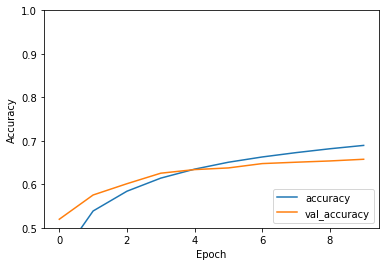

In [100]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

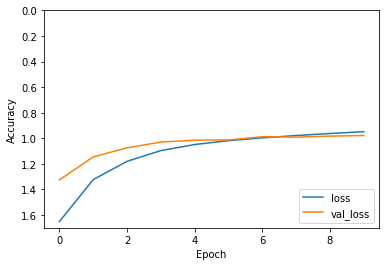

In [102]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([1.7, 0])
plt.legend(loc='lower right')

In [103]:
spa_vocab = spa_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = spa_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)

In [106]:
input_sentence="She handed him the money."
translated = decode_sequence(input_sentence)
print(translated)

[start] ella le ha [UNK] el dinero [end]


In [109]:
input_sentence="I am hungry"
translated = decode_sequence(input_sentence)
print(translated)

[start] estoy hambre [end]


In [111]:
input_sentence="My name is"
translated = decode_sequence(input_sentence)
print(translated)

[start] mi nombre es [end]


In [114]:
input_sentence="go back my friend"
translated = decode_sequence(input_sentence)
print(translated)

[start] ve de mi amigo [end]


In [115]:
input_sentence="There is a trap."
translated = decode_sequence(input_sentence)
print(translated)

[start] hay una trampa [end]
